In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import seaborn as sns
import requests
from io import BytesIO

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

In [3]:
# load in datasets
home_dir = Path().cwd().parent
df = pd.read_csv(
    home_dir / "cleaned-datasets" / "interpolated_economic_data.csv",
    engine="c", low_memory=False
)

df2 = pd.read_csv(
    home_dir / "cleaned-datasets" / "Cleaned_Meat_Stats_Meat_Production.csv",
    engine="c", low_memory=False
)

In [4]:
new_avg_unemployment = df.groupby(
    "date")[["unemployment_rate", "percent_error"]].mean().reset_index()

new_avg_unemployment['date'] = pd.to_datetime(
    new_avg_unemployment['date'], infer_datetime_format=True)
new_avg_unemployment

/tmp/ipykernel_507385/3073153132.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  new_avg_unemployment['date'] = pd.to_datetime(


,date,unemployment_rate,percent_error
0,2010-01-01,6.841047,0.151923
1,2010-02-01,6.901016,0.151923
2,2010-03-01,6.961571,0.151923
3,2010-04-01,7.022721,0.151923
4,2010-05-01,7.084477,0.151923
...,...,...,...
151,2022-08-01,5.258827,0.161538
152,2022-09-01,5.236954,0.161538
153,2022-10-01,5.212853,0.161538
154,2022-11-01,5.186454,0.161538


In [5]:
red_meat_production = df2[df2['Type of Meat'] == 'Red Meat'].reset_index()
red_meat_production['date'] = pd.to_datetime(red_meat_production['Date'], infer_datetime_format=True)
red_meat_production = red_meat_production[['date', 'Production']]
red_meat_production

poultry_production = df2[df2['Type of Meat'] == 'Poultry'].reset_index()
poultry_production['date'] = pd.to_datetime(poultry_production['Date'], infer_datetime_format=True)
poultry_production = poultry_production[['date', 'Production']]
poultry_production

/tmp/ipykernel_507385/3077109200.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  red_meat_production['date'] = pd.to_datetime(red_meat_production['Date'], infer_datetime_format=True)
/tmp/ipykernel_507385/3077109200.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  poultry_production['date'] = pd.to_datetime(poultry_production['Date'], infer_datetime_format=True)


,date,Production
0,2010-01-01,3325.3
1,2010-02-01,3198.4
2,2010-03-01,3630.8
3,2010-04-01,3569.0
4,2010-05-01,3515.3
...,...,...
151,2022-08-01,4660.2
152,2022-09-01,4500.4
153,2022-10-01,4537.3
154,2022-11-01,4453.6


<Axes: xlabel='date'>

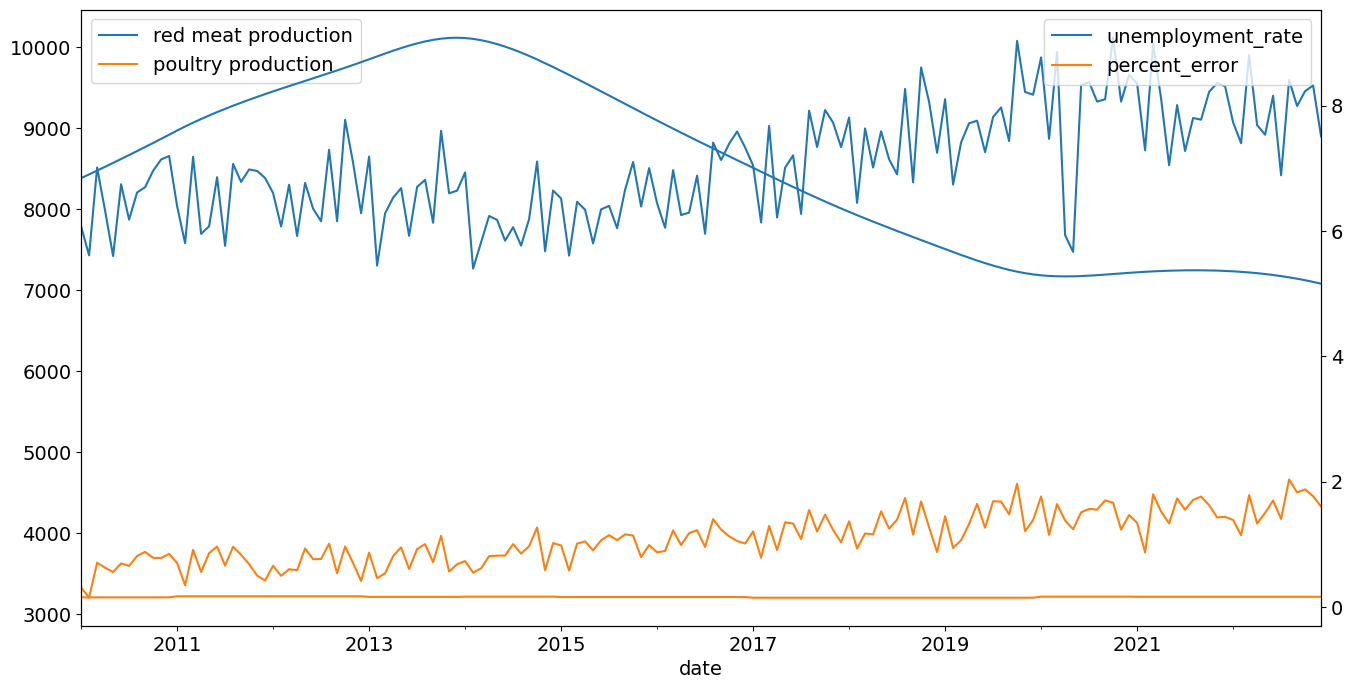

In [6]:
ax = red_meat_production.plot(x='date')
poultry_production.plot(ax=ax, x='date')
ax.legend(['red meat production', 'poultry production'])
ax2 = ax.twinx()
new_avg_unemployment.plot(ax=ax2, x='date')


In [7]:
mod_exog = sm.tsa.statespace.SARIMAX(
    endog=new_avg_unemployment['unemployment_rate'], exog=poultry_production['Production'], trend='c', order=(1, 1, 1))
fit_res_exog = mod_exog.fit(disp=False)

mod_endog = sm.tsa.statespace.SARIMAX(
    endog=new_avg_unemployment['unemployment_rate'], trend='c', order=(1, 1, 1))
fit_res_endog = mod_endog.fit(disp=False)

print(fit_res_endog.summary())
print(fit_res_exog.summary())

                               SARIMAX Results                                
Dep. Variable:      unemployment_rate   No. Observations:                  156
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 794.683
Date:                Sun, 04 Aug 2024   AIC                          -1581.367
Time:                        10:17:49   BIC                          -1569.193
Sample:                             0   HQIC                         -1576.422
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.15e-05      0.000      0.206      0.837      -0.000       0.000
ar.L1          0.9906      0.005    180.737      0.000       0.980       1.001
ma.L1          0.9457      0.025     38.234      0.0

/home/arjun/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/arjun/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [8]:
res = mod_exog.filter(fit_res_exog.params)
predict = res.get_prediction()
predict.ci = predict.conf_int()

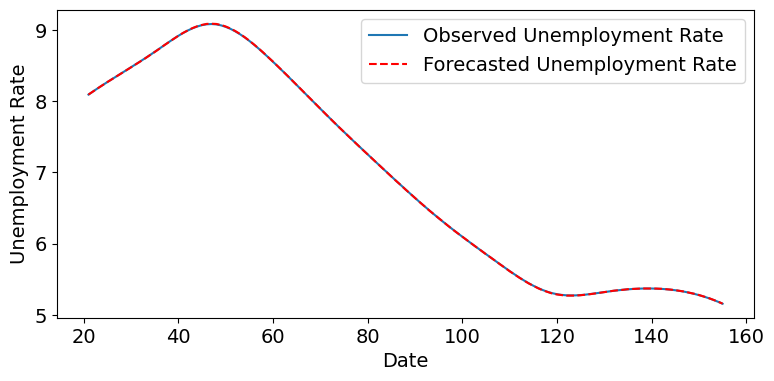

In [9]:
fig, ax = plt.subplots(figsize=(9, 4))
npre = 4
ax.set(xlabel='Date', ylabel='Unemployment Rate')

new_avg_unemployment.loc["2010-02-01":, 'unemployment_rate'].plot(x = 'date', ax=ax, style='-', label='Observed Unemployment Rate')

predict.predicted_mean.loc["2010-02-01":].plot(
    x='date', ax=ax, style='r--', label='Forecasted Unemployment Rate')

legend = ax.legend(loc='upper right')
ci = predict.conf_int().loc['2010-01-01':]

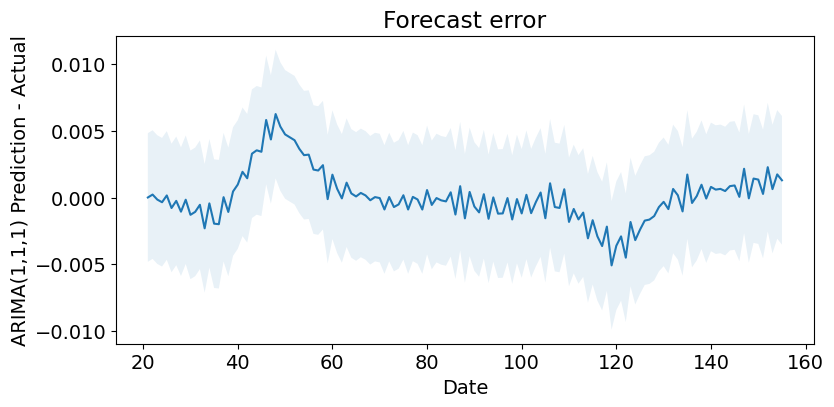

In [10]:
fig, ax = plt.subplots(figsize=(9, 4))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='ARIMA(1,1,1) Prediction - Actual')

predict_error = predict.predicted_mean - new_avg_unemployment['unemployment_rate']
predict_error.loc['2010-01-01':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict.conf_int().loc['2010-01-01':].copy()
ci.iloc[:, 0] -= new_avg_unemployment['unemployment_rate'].loc['2010-01-01':]
ci.iloc[:, 1] -= new_avg_unemployment['unemployment_rate'].loc['2010-01-01':]
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:,1], alpha=0.1)

In [11]:
# np.asarray(new_avg_unemployment.iloc[:100][['date', 'unemployment_rate']])
# np.asarray(red_meat_production.iloc[:100])

In [12]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
mod = sm.tsa.statespace.SARIMAX(
    endog=new_avg_unemployment.iloc[:100][['date', 'unemployment_rate']], 
    exog=red_meat_production.iloc[:100], 
    trend='c', order=(1, 1, 1))

nforecast = 20
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.xaxis.grid()
ax.plot(
    new_avg_unemployment.iloc[:100, 'unemployment_rate'], 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:],
        'k--', linestyle='--', linewidth=2)
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

ax.set(title='')

TypeError: Field elements must be 2- or 3-tuples, got '<class 'int'>'